Code based on AE with pytorch lighting tutorial: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/ae_sim"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

C:\Users\alexg\AppData\Local\Temp\ipykernel_61436\2116438814.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Device: cuda:0


# Dataset

In [2]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
print(train_dataset.data.shape)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

NUM_BATCHES_TRAIN = len(train_loader)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Global seed set to 42


torch.Size([60000, 28, 28])


In [3]:
EPOCHS = 300

# Model

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int,
                 linear_hidden_dims: list, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        layers =  [nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=3, stride=2), # 28x28 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            ]
        
        layer_sizes = [2*16*c_hid] + linear_hidden_dims
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1],
                                 layer_sizes[layer_index]),
                        act_fn()]
        
        layers += [nn.Linear(layer_sizes[-1], latent_dim),
                   nn.Identity()]
        
        self.net = nn.ModuleList(layers)
    
    
    def forward(self, x):
        for blk in self.net:
            x = blk(x)
            
        return x
    
    def detailed_forward(self, x):
        res = [x]
        for blk in self.net:
            x = blk(x)
            res.append(x.detach().reshape(x.shape[0], -1))
            
        return res

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 linear_hidden_dims : list,
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        
        layer_sizes =  [latent_dim] + linear_hidden_dims + [2*16*c_hid]
        linear_layers = []
        for layer_index in range(1, len(layer_sizes)):
            linear_layers += [nn.Linear(layer_sizes[layer_index-1],
                                 layer_sizes[layer_index]),
                        act_fn()]
        
        self.linear = nn.ModuleList(linear_layers)
        
        self.net = nn.ModuleList([
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=3, stride=2), # 16x16 => 28x28
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        ])
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x
    
    def forward(self, x):
        for blk in self.linear:
            x = blk(x)
        
        x = x.reshape(x.shape[0], -1, 4, 4)
        
        for blk in self.net:
            x = blk(x)

        return x
    
    def detailed_forward(self, x):
        res = []
        
        for blk in self.linear:
            x = blk(x)
            res.append(x.detach())
            
        
        x = x.reshape(x.shape[0], -1, 4, 4)
        
        for blk in self.net:
            x = blk(x)
            res.append(x.detach().reshape(x.shape[0], -1))
            
        return res

In [6]:
class Autoencoder(nn.Module):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 linear_hidden_dims : list = [],
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 ):
        super().__init__()
        
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim, linear_hidden_dims)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim, linear_hidden_dims[::-1])
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        
        return x_hat 
        
    def detailed_forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder.detailed_forward(x)
        x_hat = self.decoder.detailed_forward(z[-1])
        return z + x_hat

In [7]:
class LitAutoencoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 seed : int =42,
                 linear_hidden_dims : list = [],
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        
        pl.seed_everything(seed)

        # Creating encoder and decoder
        self.net = Autoencoder(base_channel_size, 
                               latent_dim,
                               linear_hidden_dims,
                               encoder_class,
                               decoder_class,
                               num_input_channels)
        
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
    
    def forward(self, x):
       
        return self.net(x) 
        
    def detailed_forward(self, x):
        """
        The forward function takes in an image and returns a list of all the activations
        """
        
        return self.net.detailed_forward(x)
    
    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        
        """scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                          base_lr=5e-5,
                                          max_lr=1e-3,
                                          step_size_up=(4*NUM_BATCHES_TRAIN)//2,
                                          cycle_momentum=False,
                                          mode="triangular2")"""
                                          
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-3,
                                                total_steps=EPOCHS)
        
       
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)                             
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

### Training the model

During the training, we want to keep track of the learning progress by seeing reconstructions made by our model. For this, we implement a callback object in PyTorch Lightning which will add reconstructions every $N$ epochs to our tensorboard:

In [8]:
class GenerateCallback(pl.Callback):
    
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

We will now write a training function that allows us to train the autoencoder with different latent dimensionality and returns both the test and validation score. We provide pre-trained models and recommend you using those, especially when you work on a computer without GPU. Of course, feel free to train your own models on Lisa.

In [9]:
def train_network(latent_dim, seed=24, linear_hidden_dims=[]):
    
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"MNIST_{latent_dim}_seed{seed}"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=EPOCHS, 
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    
    model = LitAutoencoder(base_channel_size=28,
                        latent_dim=latent_dim,
                        seed=seed,
                        linear_hidden_dims=linear_hidden_dims,
                        num_input_channels=1, 
                        width=28, 
                        height=28
                        )
    trainer.fit(model, train_loader, val_loader)
    
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    
    return model, result

In [ ]:
latent_dim = 2
linear_hidden_dims = [512, 256, 128, 32]

for seed in [200, 121, 2013, 2023]:
    model_ld, result_ld = train_network(latent_dim, seed=seed)

In [11]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

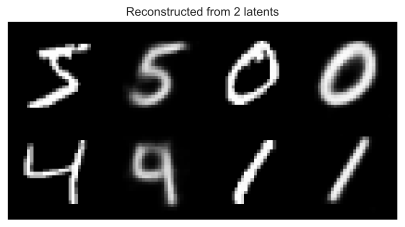

In [12]:
input_imgs = get_train_images(4)
visualize_reconstructions(model_ld, input_imgs)

### Tensorboard clustering

Another way of exploring the similarity of images in the latent space is by dimensionality-reduction methods like PCA or T-SNE. Luckily, Tensorboard provides a nice interface for this and we can make use of it in the following:

In [9]:
# Create a summary writer
writer = SummaryWriter("tensorboard/")

The function `add_embedding` allows us to add high-dimensional feature vectors to TensorBoard on which we can perform clustering. What we have to provide in the function are the feature vectors, additional metadata such as the labels, and the original images so that we can identify a specific image in the clustering. 

In [ ]:
## In case you obtain the following error in the next cell, execute the import statements and last line in this cell
##   AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# Note: the embedding projector in tensorboard is computationally heavy.
# Reduce the image amount below if your computer struggles with visualizing all 10k points
NUM_IMGS = len(test_set) 

writer.add_embedding(test_img_embeds[1][:NUM_IMGS], # Encodings per image
                     metadata=[test_set[i][1] for i in range(NUM_IMGS)], # Adding the labels per image to the plot
                     label_img=(test_img_embeds[0][:NUM_IMGS]+1)/2.0) # Adding the original images to the plot

Finally, we can run tensorboard to explore similarities among images:

In [10]:
%tensorboard --logdir saved_models/ae_sim/MNIST_2/lightning_logs/version_0

You should be able to see something similar as in the following image. In case the projector stays empty, try to start the TensorBoard outside of the Jupyter notebook.

<center><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/tensorboard_projector_screenshot.jpeg?raw=1" width="70%"/></center>

Overall, we can see that the model indeed clustered images together that are visually similar. Especially the background color seems to be a crucial factor in the encoding. This correlates to the chosen loss function, here Mean Squared Error on pixel-level because the background is responsible for more than half of the pixels in an average image. Hence, the model learns to focus on it. Nevertheless, we can see that the encodings also separate a couple of classes in the latent space although it hasn't seen any labels. This shows again that autoencoding can also be used as a "pre-training"/transfer learning task before classification.

In [ ]:
# Closing the summary writer
writer.close()